# Language Model for English Words #

In the notebook `LM RNN` I trained a language model over English pronunciations from [the CMU Pronouncing Dictionary](http://www.speech.cs.cmu.edu/cgi-bin/cmudict). The pronunciations in the pronouncing dictionary are in ARPABET, a set of symbols representing English sounds. It's a subset of the more popular [International Phonetic Alphabet](https://en.wikipedia.org/wiki/International_Phonetic_Alphabet).

In this notebook I use the model to:
1. Identify which English pronunciations are most- and least-Englishlike. For example, I would expect "fun" to sound normal and a borrowed word like "cliché" to be less normal.
2. Generate novel words that aren't English words but sound like they could be.

I'll also dig into what the model has learned to see whether it has learned the [phonotactics rules](https://en.wikipedia.org/wiki/Phonotactics) that all English speakers subconsciously understand.

In [483]:
from operator import itemgetter

import pandas as pd
import torch
from matplotlib import pyplot as plt

from utils import load_data

In [111]:
pd.options.display.max_rows = 500
pd.options.display.max_columns = 100
pd.options.display.max_colwidth = 255

In [11]:
with open('lm_2.pt', 'rb') as fh:
    lm = torch.load(fh, map_location=torch.device('cpu'))
lm.device = torch.device('cpu')

/Users/colin/code/sonorous/venv/lib/python3.7/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'phoneme_lm.PhonemeLM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [9]:
df = load_data(include_stress=True)

In [763]:
print(f'There are {len(df):,} pronunciations.')
df.sample(5)

There are 124,996 pronunciations.


,pronunciation,length,probability,perplexity,pronunciation_string,num_syllables
word,,,,,,
reisig,"(R, AY1, S, IH0, G)",5,7.795751e-08,26.401488,R AY1 S IH0 G,2
knelt,"(N, EH1, L, T)",4,1.048781e-06,31.248476,N EH1 L T,1
yearwood,"(Y, IH1, R, W, UH0, D)",6,1.341753e-09,30.110727,Y IH1 R W UH0 D,2
fewest,"(F, Y, UW1, AH0, S, T)",6,9.892206e-07,10.018079,F Y UW1 AH0 S T,2
magaziner,"(M, AE2, G, AH0, Z, IY1, N, ER0)",8,6.338548e-10,14.117288,M AE2 G AH0 Z IY1 N ER0,4


# MOVE ME #

In [599]:
# TODO: write a utility function for extracting all probabilities. Then use that in this. Also add a function for perplexity
def calc_probs(lm, pronunciation):
    from phoneme_lm import encode_pronunciation
    from torch.functional import F
    encoded_pronunciation = encode_pronunciation(
        pronunciation,
        lm.phoneme_to_idx
    )
    output, _ = lm(torch.LongTensor(encoded_pronunciation).unsqueeze(0))
    output = F.softmax(output, dim=-1).squeeze()

    probs = []
    for step, (input_phoneme_idx, next_phoneme_idx) in enumerate(zip(encoded_pronunciation, encoded_pronunciation[1:])):
        prob = output[step, next_phoneme_idx].item()
        probs.append(prob)

    return probs

def plot_pronunciation(lm, pronunciation):
    probs = calc_probs(lm, pronunciation)
    pronunciation = pronunciation + ('END',)
    pd.Series(probs, pronunciation).plot.bar()
    plt.title('Probability of Each Phoneme Given Word So Far')
    
    
def plot_next_probabilities(lm, pronunciation, min_prob=0.01):
    """Compute the probabilities for the next phoneme after `pronunciation`.
    
    Plot all phonemes that have at least `min_prob` probability.
    """
    next_probs = lm.next_probabilities(pronunciation)
    # TODO: remove this after fixing bug in phoneme_lm.py
    next_probs = {phoneme: prob.item() for (phoneme, prob) in next_probs.items()}
    next_probs = pd.Series(next_probs)
    next_probs = next_probs[next_probs>=min_prob].sort_values(ascending=False)
    next_probs.plot.bar()

# TODO: put this on the model
def calculate_perplexity(lm, pronunciation):
    return lm.calculate_probability(pronunciation) ** -(1/5)

In [764]:
# meow TODO: move this. maybe intil utils?
def make_vowels_set():
    """Return a set of all stressed vowels, each as an ARPABET string.
    
    Note that this also includes the syllabir /ER/.
    """
    unstressed_vowels = {'AA', 'AE', 'AH', 'AO', 'AW', 'AY', 'EH', 'ER', 'EY', 'IH', 'IY', 'OW', 'OY', 'UH', 'UW' }
    vowels = set()
    for vowel in unstressed_vowels:
        for stress in '012':
            vowels.add(f'{vowel}{stress}')
    return vowels

vowels = make_vowels_set()

def count_vowels_in_pronunciation(pronunciation, vowels):
    counts = Counter(pronunciation)
    return sum(counts[vowel] for vowel in vowels)
        
# Assuming that each vowel corresponds to a single syllable, which is correct most of the time.
df['num_syllables'] = df.pronunciation.apply(lambda pronunciation: count_vowels_in_pronunciation(pronunciation, vowels))


def make_dist(things):
    counts = things.value_counts()
    return counts / counts.sum()

## What Words are the Most and Least Englishy? ##
Since the model can assign a probability to any pronunciation, I can run it over the entire set of pronunciations in the Pronouncing Dictionary and identify the ones that have high and low likelihood of being English.

I'll be using [perplexity](https://en.wikipedia.org/wiki/Perplexity) as a measurement of how likely the model thinks each pronunciation is.

In [765]:
# meow: make a `lm.calculate_perplexity` method. Drop probability since it's not really useful
def perplexity(row):
    return row['probability'] ** -(1 / row['length'])

df['probability'] = df.pronunciation.apply(lambda pronunciation: lm.calculate_probability(pronunciation))
df['perplexity'] = df.apply(perplexity, axis=1)

Let's look at the least perplexing words. These are the ones the model was totally unsurprised because they seem very normal. Remember that the pronunciation is in [ARPABET](https://en.wikipedia.org/wiki/ARPABET).

In [773]:
least_perplexing = df.sort_values('perplexity').loc[:, ['pronunciation', 'perplexity']].head(10)
least_perplexing

,pronunciation,perplexity
word,,
kenton,"(K, EH1, N, T, AH0, N)",7.777964
canton,"(K, AE1, N, T, AH0, N)",8.047631
kinton,"(K, IH1, N, T, AH0, N)",8.181406
menton,"(M, EH1, N, T, AH0, N)",8.441340
brenton,"(B, R, EH1, N, T, AH0, N)",8.497725
korten,"(K, AO1, R, T, AH0, N)",8.500336
carton,"(K, AA1, R, T, AH0, N)",8.510653
contant,"(K, AA1, N, T, AH0, N, T)",8.627808
cantons,"(K, AE1, N, T, AH0, N, Z)",8.652958


The least perplexing words have long spans of phonemes that are very common in Enligh. To get better intuitions about the model's "thinking" along the way we can look at the probability the model assigned to each phoneme. In the chart below, the phonemes occur along the X-axis. At the `i`th phoneme the Y-axis value represents how likely the model thought this character is given everything it's seen so far. For example, at the third phoneme below (/N/) the probability of ~.5 means the model thinks that after seeing /K AA2/ the probability of /N/ coming next is .5. In other words, `P(N | K AA2) = 0.5)`.

In [774]:
least_perplexing.pronunciation.iloc[0]

('K', 'EH1', 'N', 'T', 'AH0', 'N')

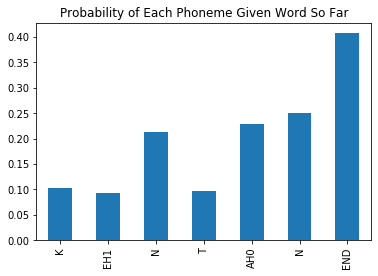

In [775]:
plot_pronunciation(lm, least_perplexing.iloc[0].pronunciation)

It is clear that the model has memorized some of these longer words. In the word "constitutionists" above, early on perplexity is high as the model was trained on many words that had that same beginning. Further on the model is fairly certain, like where it believes /SH/ should almost certaintly follow /K AH2 N S T AH0 T UW1/. Phonotactically many of phonemes would be fine here.


It makes sense that the model would be able to overfit on long words. What short words are most perplexing to the model? Let's look at the most perplexing two syllable words.

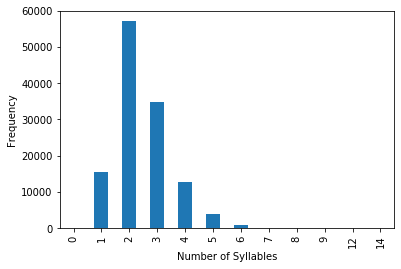

In [776]:
df.num_syllables.value_counts().sort_index().plot.bar()
plt.xlabel('Number of Syllables')
_ = plt.ylabel('Frequency')

In [777]:
percentage_2to3 = (df.num_syllables==2).mean() * 100
print('{:.0f}% of words contain two syllables\n'.format(percentage_2to3))

46% of words contain two syllables



About 46% of English words contain two syllables. So let's look in this area.

In [778]:
df_2 = df[df.num_syllables==2]
df_2.sort_values('perplexity').loc[:, ['pronunciation_string', 'perplexity', 'length', 'num_syllables']].drop_duplicates('pronunciation_string').head(10)

,pronunciation_string,perplexity,length,num_syllables
word,,,,
kenton,K EH1 N T AH0 N,7.777964,6,2
canton,K AE1 N T AH0 N,8.047631,6,2
kinton,K IH1 N T AH0 N,8.181406,6,2
menton,M EH1 N T AH0 N,8.441340,6,2
brenton,B R EH1 N T AH0 N,8.497725,7,2
korten,K AO1 R T AH0 N,8.500336,6,2
carton,K AA1 R T AH0 N,8.510653,6,2
contant,K AA1 N T AH0 N T,8.627808,7,2
cantons,K AE1 N T AH0 N Z,8.652958,7,2


In [779]:
df[df.num_syllables > 3].sort_values('perplexity').loc[:, ['pronunciation_string', 'perplexity', 'length', 'num_syllables']].drop_duplicates('pronunciation_string').head(10)

,pronunciation_string,perplexity,length,num_syllables
word,,,,
kenealy,K EH1 N IY0 AH0 L IY0,10.499667,7,4
contaminant,K AH0 N T AE1 M AH0 N AH0 N T,11.122940,11,4
cinnamonson,S IH1 N AH0 M AH0 N S AH0 N,11.196613,10,4
minimally,M IH1 N AH0 M AH0 L IY0,11.357341,8,4
cynically,S IH1 N IH0 K AH0 L IY0,11.528573,8,4
frantically,F R AE1 N T AH0 K AH0 L IY0,11.536430,10,4
canonical,K AH0 N AA1 N AH0 K AH0 L,11.647248,9,4
contrarians,K AH0 N T R EH1 R IY0 AH0 N Z,11.683093,11,4
criminally,K R IH1 M AH0 N AH0 L IY0,11.738775,9,4


All of these words have three syllables with the stress on the second syllable. These all feel like good English words. They have many phonemes though, so I'm concerned that the model is recognizing the very specific patterns and giving all the later phonemes very high probabilities.

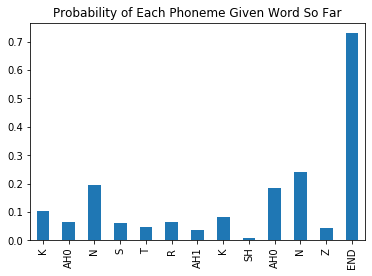

In [784]:
plot_pronunciation(lm, ('K', 'AH0', 'N', 'S', 'T', 'R', 'AH1', 'K', 'SH', 'AH0', 'N', 'Z'))

In [785]:
df_2.sort_values('perplexity', ascending=False).head(10)

,pronunciation,length,probability,perplexity,pronunciation_string,num_syllables
word,,,,,,
ia,"(IY1, AH0)",2,6.001252e-07,1290.859749,IY1 AH0,2
oyer,"(OY1, ER0)",2,7.782746e-07,1133.531469,OY1 ER0,2
aja,"(AY1, AH0)",2,1.035474e-06,982.721311,AY1 AH0,2
awry,"(ER0, AY1)",2,1.296925e-06,878.097263,ER0 AY1,2
auer,"(AW1, ER0)",2,1.653131e-06,777.761372,AW1 ER0,2
our,"(AW1, ER0)",2,1.653131e-06,777.761372,AW1 ER0,2
hour,"(AW1, ER0)",2,1.653131e-06,777.761372,AW1 ER0,2
array,"(ER0, EY1)",2,2.457984e-06,637.838074,ER0 EY1,2
aoi,"(AW1, IY0)",2,2.848446e-06,592.510421,AW1 IY0,2


Interestingly these words do all feel very weird to me as an English speaker. "ai" is an acronym, pronounced as the letter 'A' followed by the letter 'I', so isn't held to normal word formation properties and would be a really strange word.

"zungu" also doesn't sound like English. Since English prefers syllables with onsets, when saying the word I feel like I want /NG/ to be the onset of the second syllable /NG UW1/. But /NG/ isn't normally allowed as the onset of a syllable.

The stress pattern is also weird on this word. Normally in a two syllable word there will be one stressed syllable and one unstressed. This word has primary stress on the second syllabie (/UW1/) and secondary stressed on the first syllable (/AH2/). Interestingly, the perplexity of the word drops considerably (to 450) when I replace /AH2/ with /AH1/.

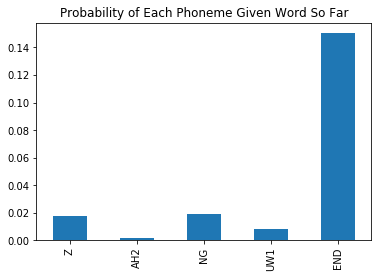

In [786]:
plot_pronunciation(lm, ('Z', 'AH2', 'NG', 'UW1'))

We've seen that the lowest perplexity words are very long and the highest perplexity words are short. Let's look at the two other options. First let's look at the low perplexity short words.

In [787]:
df_2 = df[df.num_syllables==2]
df_2.sort_values('perplexity').drop_duplicates('pronunciation').head()

,pronunciation,length,probability,perplexity,pronunciation_string,num_syllables
word,,,,,,
kenton,"(K, EH1, N, T, AH0, N)",6,4.516526e-06,7.777964,K EH1 N T AH0 N,2
canton,"(K, AE1, N, T, AH0, N)",6,3.681220e-06,8.047631,K AE1 N T AH0 N,2
kinton,"(K, IH1, N, T, AH0, N)",6,3.334513e-06,8.181406,K IH1 N T AH0 N,2
menton,"(M, EH1, N, T, AH0, N)",6,2.763959e-06,8.441340,M EH1 N T AH0 N,2
brenton,"(B, R, EH1, N, T, AH0, N)",7,3.125226e-07,8.497725,B R EH1 N T AH0 N,2


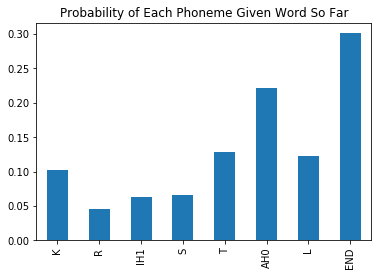

In [788]:
plot_pronunciation(lm, ('K', 'R', 'IH1', 'S', 'T', 'AH0', 'L'))

Despite being only two syllables, these words are packed with phonemes, with lots complex onsets and codas. Let's look at words that are three or fewer phonemes.

In [789]:
df[df.length <= 3].sort_values('perplexity').drop_duplicates('pronunciation').head()

,pronunciation,length,probability,perplexity,pronunciation_string,num_syllables
word,,,,,,
kanne,"(K, AE1, N)",3,0.000197,17.183204,K AE1 N,1
kenn,"(K, EH1, N)",3,0.000164,18.256794,K EH1 N,1
kinne,"(K, IH1, N)",3,0.000151,18.781681,K IH1 N,1
keene,"(K, IY1, N)",3,0.000126,19.957942,K IY1 N,1
man,"(M, AE1, N)",3,0.000121,20.208772,M AE1 N,1


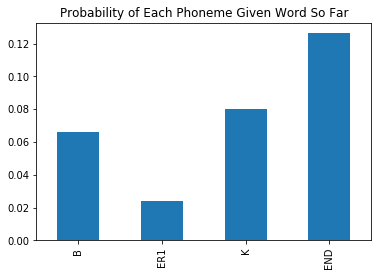

In [790]:
plot_pronunciation(lm, ('B', 'ER1', 'K'))

These words are all of the form ONSET VOWEL CODA. Overall they all sound like standard words.

Now lets look at long and perplexing words.

Let's now look at the words the model thinks are most perplexing (i.e. least likely).

In [792]:
df[df.num_syllables > 4].sort_values('perplexity', ascending=False).head()

,pronunciation,length,probability,perplexity,pronunciation_string,num_syllables
word,,,,,,
genego,"(JH, IY1, IY1, EH1, N, IY1, JH, IY1, OW1)",9,2.680409e-24,415.995634,JH IY1 IY1 EH1 N IY1 JH IY1 OW1,6
asean,"(EY1, EH1, S, IY1, EY1, EH1, N)",7,2.676882e-17,233.067400,EY1 EH1 S IY1 EY1 EH1 N,5
sffed,"(EH1, S, EH1, F, EH1, F, IY1, D, IY1)",9,7.623448e-21,171.916082,EH1 S EH1 F EH1 F IY1 D IY1,5
waga,"(D, AH1, B, AH0, Y, UW2, EY1, JH, IY1, EY1)",10,7.126496e-23,163.950368,D AH1 B AH0 Y UW2 EY1 JH IY1 EY1,6
anfal,"(EY1, EH1, N, EH1, F, EY1, EH1, L)",8,4.054258e-18,149.283247,EY1 EH1 N EH1 F EY1 EH1 L,5


Aside from "gunatilake", all of these words are acronyms. For example, "wor" is each letter in the word pronounced.

## Which Pronunciation Wins for Words with Multiple Pronunciations? ##
Another interesting thing we can look at is which pronunciation the model prefers when a word has multiple standard ones.

In [793]:
# TODO: to analysis_utils
def show_pronunciations_for_word(word):
    df_for_word = df.loc[word].sort_values('perplexity', ascending=False).loc[:, ['pronunciation_string', 'perplexity']]
    display(df_for_word.sort_values('perplexity'))

Let's look at the model's preferred pronunciations for three words commonly argued over.

In [794]:
show_pronunciations_for_word('tomato')
show_pronunciations_for_word('aunt')
show_pronunciations_for_word('nevada')

,pronunciation_string,perplexity
word,,
tomato,T AH0 M AA1 T OW2,35.394612
tomato,T AH0 M EY1 T OW2,38.305575


,pronunciation_string,perplexity
word,,
aunt,AE1 N T,32.791717
aunt,AO1 N T,57.522401


,pronunciation_string,perplexity
word,,
nevada,N AH0 V AE1 D AH0,29.297740
nevada,N AH0 V AA1 D AH0,30.311586


The model agrees with (what I take to be) the more common pronunciation of the first two words but thinks "Nevada" is different than how I say it.

Let's look at "coupon" now.

In [795]:
show_pronunciations_for_word('coupon')

,pronunciation_string,perplexity
word,,
coupon,K UW1 P AO2 N,43.930078
coupon,K Y UW1 P AO2 N,51.788406


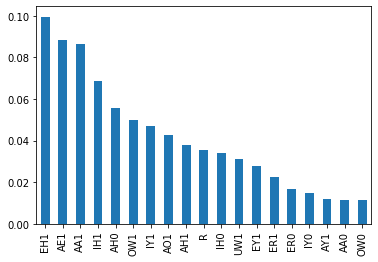

In [797]:
plot_next_probabilities(lm, ('K', 'Y'))

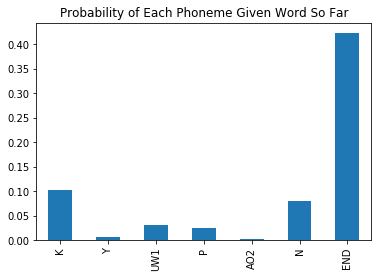

In [796]:
plot_pronunciation(lm, tuple('K Y UW1 P AO2 N'.split()))

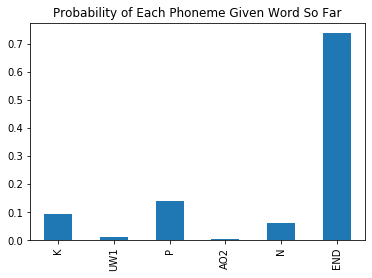

In [425]:
plot_pronunciation(lm, tuple('K UW1 P AO2 N'.split()))

The model prefers the "YU" less version of "coupon". Interestingly, in this case the relatively low perplexity seems to be due to the model being very certain that /UW1/ will follow /K Y/.

"with" has four possible pronunciations listed.

In [432]:
show_pronunciations_for_word('with')

,pronunciation_string,perplexity
word,,
with,W IH1 TH,62.837700
with,W IH0 TH,111.047932
with,W IH1 DH,134.248276
with,W IH0 DH,249.268583


By far the least perplexing one is the one I personally would use. The Pronouncing Dictionary includes two pronunciatinos with an unstressed vowel. When actually spoken in a sentence it'd be common to not stress that vowel, but when just saying the word on its own I would think it should have stress.

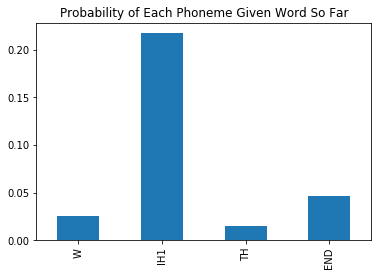

In [435]:
plot_pronunciation(lm, ('W', 'IH1', 'TH'))

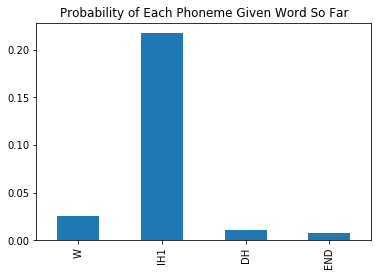

In [434]:
plot_pronunciation(lm, ('W', 'IH1', 'DH'))

The model also strongly believes "with" should end with the voiceless /TH/ instead of the voiced /DH/. It looks like this is due to the model not wanting to end the word at /W IH1 DH/, probably because ending any word with /IH1 DH/ is rare.

## Can the Model Generate Novel Words? ##

* proportion of words that are novel
* proportion of words (from a sample) that look good to me
* 10 randomly sampled words. show them and play the word. ARPABET | IPA | my best spelling guess | play button 


compare with overgenerated model. probably way more that aren't novel

In [798]:
generated_df = pd.DataFrame({
    'pronunciation': [
        lm.generate(max_length=1000, temperature=None)
        for _ in range(10000)
    ]
})

In [799]:
generated_df['length'] = generated_df.pronunciation.apply(len)
generated_df['num_syllables'] = generated_df.pronunciation.apply(lambda pronunciation: count_vowels_in_pronunciation(pronunciation, vowels))
generated_df['is_novel_word'] = ~generated_df.pronunciation.isin(df.pronunciation)


# Occasionally the model generates an empty string. I can just prevent that.
generated_df = generated_df[generated_df.length>0]

I generated 10,000 new pronunciations. Of those, 75% are novel pronunciations and 25% were in the training set.

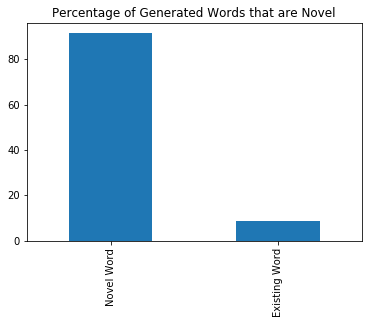

In [800]:
def show_proportion_novel(generated_df):
    counts = generated_df.is_novel_word.value_counts()
    percentages = counts / counts.sum() * 100
    
    percentages.index = percentages.index.map({True: 'Novel Word', False: 'Existing Word'})
    percentages.plot.bar()
    plt.title('Percentage of Generated Words that are Novel')

show_proportion_novel(generated_df)    

Here are some randomly generated proununciations. I'm printing five pronunciations for each syllable count. Note that these are all novel words.

In [514]:
new_pronunciations_df = generated_df[generated_df.is_novel_word]

for num_syllables in range(1, 5):
    print(f'These have {num_syllables} syllables')
    
    for pronunciation in new_pronunciations_df[new_pronunciations_df.num_syllables==num_syllables].sample(5).pronunciation:
        print(f'\t{pronunciation}')

These have 1 syllables
	('HH', 'IH1', 'M', 'P', 'S')
	('S', 'T', 'AO1', 'T')
	('B', 'EH1', 'L', 'G')
	('N', 'IY1', 'M')
	('V', 'AA1', 'M')
These have 2 syllables
	('F', 'AE1', 'L', 'IY0', 'Z')
	('D', 'AA1', 'N', 'IH0', 'S')
	('IH1', 'S', 'M', 'OW0')
	('HH', 'IH1', 'M', 'AA0', 'T')
	('M', 'AA1', 'Z', 'IH0', 'K')
These have 3 syllables
	('IH0', 'G', 'EY1', 'B', 'IH0', 'N')
	('K', 'R', 'IH1', 'S', 'T', 'IH0', 'T', 'IY0')
	('IH0', 'N', 'D', 'R', 'AY1', 'B', 'AH0', 'S')
	('AA1', 'P', 'T', 'AH0', 'M', 'IY0')
	('AE2', 'M', 'D', 'EY1', 'IH0', 'NG')
These have 4 syllables
	('S', 'AH2', 'B', 'S', 'AH0', 'L', 'EH1', 'S', 'T', 'IH0', 'D')
	('K', 'EH2', 'R', 'AH0', 'L', 'IY1', 'N', 'D', 'ER0')
	('V', 'IH1', 'Z', 'AH0', 'T', 'ER0', 'IH0', 'JH')
	('V', 'IY0', 'V', 'EY1', 'D', 'IY0', 'AH0', 'N')
	('K', 'ER0', 'T', 'AA1', 'G', 'R', 'AH0', 'F', 'ER0')


The main thing that jumps out at me is that these all sound like conceivable English words. There are a few sort of awkward words, like /G OW1 JH D/, but there's nothing unpronouncable. And the stress patterns feel natural to me.



The length of the words the model generates (both in terms of phonemes and syllables) is fairly similar to the training data.

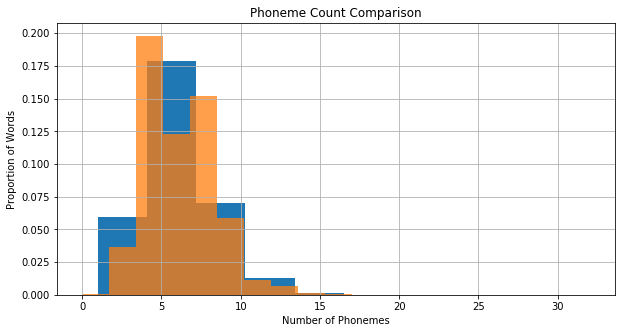

In [531]:
df.length.hist(density=True)
generated_df.length.hist(density=True, alpha=.75, figsize=(10, 5))
plt.xlabel('Number of Phonemes')
plt.ylabel('Proportion of Words')
_ = plt.title('Phoneme Count Comparison')

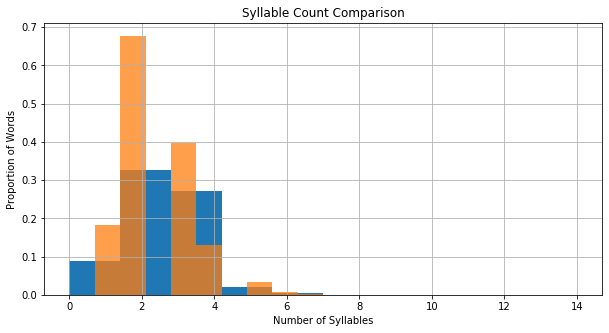

In [532]:
df.num_syllables.hist(density=True)
generated_df.num_syllables.hist(density=True, alpha=.75, figsize=(10, 5))
plt.xlabel('Number of Syllables')
plt.ylabel('Proportion of Words')
_ = plt.title('Syllable Count Comparison')

In the next section I'll probe the model to figure out whether it's just getting lucky or has learned something.

## What Rules is the Model Actually Learning? ##

Given the overfitting examples we saw earlier where the model had memorized "constitutional" and similar words, I wanted to probe the model to make sure it's learning some more general properties.

An interesting place to start is at the start of each generated pronunciation. Here are the probabilities for the first phoneme in a word:

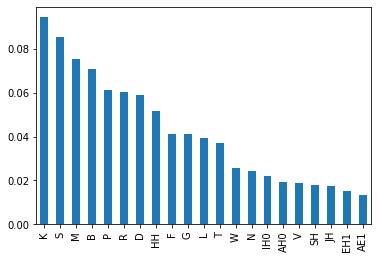

In [558]:
plot_next_probabilities(lm, ())

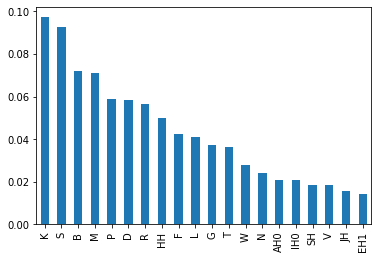

In [564]:
make_dist(df.pronunciation.apply(itemgetter(0)))[:20].plot.bar()

The model's probabilities almost exactly match the actual distribution of first phonemes in the training set. I was hoping that the model might learn some more general properties, like that obstruents (e.g. /K/, /P/, /D/) are equally likely to occur at the beginning of the word, but I appear to have given the model enough capacity to learn more specific sound transition probabilities. This is arguably better since the model can differentiate between very likely English pronunciations instead of just valid ones.

Some quick background on English word structure first. Words are composed of syllables. A syllable consists of an onset, a nucleus, and a coda. The nucleus is usually a vowel (or syllablic consonant like /ER/). The syllable /K R EH1 P T/ has /K R/ in the onset, /EH1/ in the nucleus, and /P T/ in the coda.

English prefers that syllables at the end of a word have a coda. Consonants can serve as the codas of syllables. Diphthongs (/EY/, /OW/, /AW/, /OY/, /IY/) also have coda.

Compare the two pronunciations below, /K EY1/ and /KEH1/.

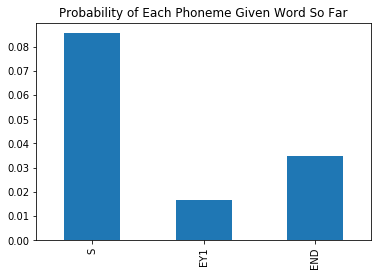

In [577]:
# TODO: plot these together
plot_pronunciation(lm, ("S", "EY1"))

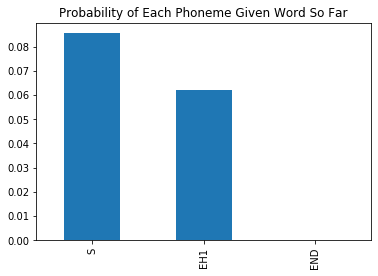

In [581]:
plot_pronunciation(lm, ("S", "EH1"))

After /S EY1/ the model assigns a 3% probability of the word ending. But /S EH1/ doesn't have a coda, so the model assigns a 0% probability of the word ending.

By closing /S EH1/ with /D/ below, we create a complete word.

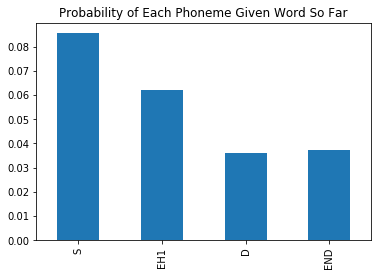

In [584]:
plot_pronunciation(lm, ("S", "EH1", "D"))

The model also seems to have learned some intersting stress patterns.

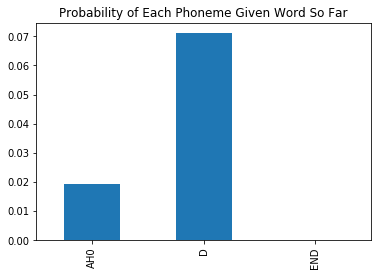

In [585]:
plot_pronunciation(lm, ('AH0', 'D'))

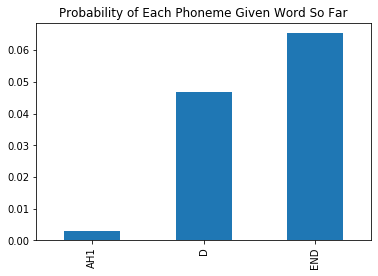

In [586]:
plot_pronunciation(lm, ('AH1', 'D'))

It knows that the word /AH0 D/ is very unlikely (it assigns a 0 probability to the word ending there) because a word has to have some stress in it. /AH1 D/ is fine though because it's stressed.

The model also learned patterns about stress over multiple syllables. A *foot* is a pair of syllables. A *trochee* contains a stressed syllable followed by an unstressed one. And an *iamb* is an unstressed syllable followed by a stressed one.

English, in general, prefers trochees. This implies that the model should assign a lower perplexity to trochees than iambs.

In [609]:
print('Trochee: {:.2f}'.format(calculate_perplexity(lm, ("T", "R", "OW1", "K", "IY0"))))
print('Iamb:    {:.2f}'.format(calculate_perplexity(lm, ("T", "R", "OW0", "K", "IY1"))))

Trochee: 18.28
Iamb:    51.43


In [610]:
print('Trochee: {:.2f}'.format(calculate_perplexity(lm, ("F", "OW1", "T", "W", "AH0", "Z"))))
print('Iamb:    {:.2f}'.format(calculate_perplexity(lm, ("F", "OW0", "T", "W", "AH1", "Z"))))

Trochee: 59.04
Iamb:    235.56


It does in fact prefer the trochee versions in both cases.

Another English phonotactic rule, from Wikipedia, is: "Two obstruents in the same coda must share voicing (compare kids /K IH1 D Z/ with kits /K IH1 T S/)". Hopefully the model will assign a higher perplexity when this rule is violated below.

In [714]:
print('Perplexity for /T EH1 B Z/: {:.0f}'.format(calculate_perplexity(lm, ('T', 'EH1', 'B', 'Z'))))
print('Perplexity for /T EH1 B S/: {:.0f}'.format(calculate_perplexity(lm, ('T', 'EH1', 'B', 'S'))))
print()
print('Perplexity for /T EH1 P S/: {:.0f}'.format(calculate_perplexity(lm, ('T', 'EH1', 'P', 'S'))))
print('Perplexity for /T EH1 P Z/: {:.0f}'.format(calculate_perplexity(lm, ('T', 'EH1', 'P', 'Z'))))

Perplexity for /T EH1 B Z/: 15
Perplexity for /T EH1 B S/: 60

Perplexity for /T EH1 P S/: 18
Perplexity for /T EH1 P Z/: 34


Perplexity is higher when the two phonemes in the coda do not match in voicing. The model could just be learning that adjacent phonemes should ideally share voicing though. To test whether it's actually learned the rule about voicing in codas I'll change the syllable structure.

In [720]:
print('Perplexity for /T EH1 B Z AH0/: {:.0f}'.format(calculate_perplexity(lm, ('T', 'EH1', 'B', 'Z', 'AH0'))))
print('Perplexity for /T EH1 B S AH0/: {:.0f}'.format(calculate_perplexity(lm, ('T', 'EH1', 'B', 'S', 'AH0'))))
print()
print('Perplexity for /T EH1 P Z AH0/: {:.0f}'.format(calculate_perplexity(lm, ('T', 'EH1', 'P', 'Z', 'AH0'))))
print('Perplexity for /T EH1 P S AH0/: {:.0f}'.format(calculate_perplexity(lm, ('T', 'EH1', 'P', 'S', 'AH0'))))

Perplexity for /T EH1 B Z AH0/: 91
Perplexity for /T EH1 B S AH0/: 95

Perplexity for /T EH1 P Z AH0/: 25
Perplexity for /T EH1 P S AH0/: 24


These four words are identical to the first except that I've inserted /AH0/ to the end of the word, which allows the /S/ and /Z/ to form a second syllable with it. Since /S/ and /Z/ become onsets of the next syllable they're not subject to the constraint on the previous syllable's coda.

## Probing the Embeddings (WIP) ##

In [ ]:
def most_similar_phonemes(lm, embedding, topn=10):
    other_to_sim = {
        phoneme: cosine_similarity(lm.embedding_for(phoneme), embedding).item()
        for phoneme in phoneme_to_idx

    }

    for other_phoneme, similarity in sorted(other_to_sim.items(), key=lambda p: -p[1])[:topn]:
        print(f'[{similarity:.3f}]\t{other_phoneme}')
        
most_similar_phonemes(lm, lm.embedding_for('DH'))

In [ ]:
# For consonants
# - voicing
# - place: bilabial, dental, alveolar, palatal, velar
# - manner: stop, fricative, nasal

# For vowels
# - front/back
# - closed/open
# - rounding

# General
# - syllabic

# TODO: combine multiple vectors together, e.g. {B, G, V, DH, D} for voiced
voicing = lm.embedding_for('B') - lm.embedding_for('P')
forwarding = lm.embedding_for('P') - lm.embedding_for('K')
frication = lm.embedding_for('F') - lm.embedding_for('P')

# new = lm.embedding_for('TH') + voicing
new = lm.embedding_for('K') + voicing
# new = lm.embedding_for('T') + frication
# new = lm.embedding_for('G') + forwarding

phoneme_to_sim = {}
for phoneme in phoneme_to_idx:
    this_embs = lm.embedding_for(phoneme)
    sim = cosine_similarity(new, this_embs).item()
    phoneme_to_sim[phoneme] = sim

sorted(phoneme_to_sim.items(), key=lambda p: -p[1])[:10]

In [ ]:
import numpy as np
# np.mean([embedding_for('B'), embedding_for('V')], axis=0)
voiced = np.mean([lm.embedding_for(phoneme) for phoneme in ['B', 'V', 'G', 'Z', 'ZH', 'DH', 'JH']], axis=0)
voiceless = np.mean([lm.embedding_for(phoneme) for phoneme in ['P', 'F', 'K', 'S', 'SH', 'TH', 'CH']], axis=0)
voicing = voiced - voiceless
most_similar_phonemes(lm, voicing + lm.embedding_for('S'))

In [ ]:
from phoneme_lm import START, END, PAD
def analogy(lm, a, b, c):
    """
    a - b = c - w
    argmax(w) over sim(w, c - a + b)
    """
    emb_a = lm.embedding_for(a)
    emb_b = lm.embedding_for(b)
    emb_c = lm.embedding_for(c)
    
    all_phonemes = set(lm.vocab) - {START, END, PAD}
    
    phoneme_to_sim = {}
    for phoneme in all_phonemes:
        if phoneme in {a, b, c}:
            continue
        
        emb_p = lm.embedding_for(phoneme)
        sim = cosine_similarity(emb_p, emb_c - emb_a + emb_b)
        phoneme_to_sim[phoneme] = sim.item()
    return phoneme_to_sim

analogies = analogy(lm, 'P', 'K', 'D')
for phoneme, sim in sorted(analogies.items(), key=lambda p: -p[1]):
    print(f'[{sim:.4f}] {phoneme}')
